In [ ]:
# Requirements
!pip install torch pandas efficientnet-pytorch skorch

In [ ]:
# Imports

# python libraties
%matplotlib inline
import matplotlib
import os, cv2,itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
from PIL import Image
from skimage import io, transform
import pickle
import seaborn as sn


# pytorch libraries
import torch
from torch import optim,nn
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
from torchvision import models,transforms
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F
from torchvision import transforms
from efficientnet_pytorch import EfficientNet

# skorch libraries
import skorch
from skorch import NeuralNetClassifier
from skorch.helper import predefined_split
from skorch.callbacks import LRScheduler
from skorch.callbacks import Freezer
from skorch.callbacks import Checkpoint
from skorch.callbacks import Callback
from skorch.callbacks import EarlyStopping
from skorch.helper import predefined_split
from skorch.dataset import Dataset

# sklearn libraries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
print(os.getcwd())
data_dir = '/content/drive/MyDrive/sanj/ISIC 2018/'
# data_dir = './ISIC 2018/'

/content


In [ ]:
# Inspect gold standard lesion diagnosis
df = pd.read_csv(os.path.join(data_dir,'ISIC2018_Task3_Training_GroundTruth.csv'))
df.head(3)

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Specify what the acronyms mean
lesion_type_dict = {
    'MEL': 'Melanoma',
    'NV': 'Melanocytic nevi',
    'BCC': 'Basal cell carcinoma',
    'AKIEC': 'Actinic keratoses', # Corrected from 'AK'
    'BKL': 'Benign keratosis-like lesions',
    'DF': 'Dermatofibroma',
    'VASC': 'Vascular lesions'
}

In [ ]:
df

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
10010,ISIC_0034316,1.0,0.0,0.0,0.0,0.0,0.0,0.0
10011,ISIC_0034317,1.0,0.0,0.0,0.0,0.0,0.0,0.0
10012,ISIC_0034318,0.0,0.0,0.0,0.0,1.0,0.0,0.0
10013,ISIC_0034319,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Create column dx in our dataframe to hold diagnosis acronyms
# df = pd.read_csv(os.path.join('ISIC_2019_Training_GroundTruth.csv'))
df = df.set_index('image')
# df = df.drop(['UNK'],axis=1)  # On this occasion we won't use this column.
i, j = np.where(df)
dx = pd.Series(df.columns[j], i)
dx_df = pd.Series.to_frame(dx)
df = df.reset_index()
df_original = pd.concat([df, dx_df], axis=1, sort=False)
df_original = df_original.rename(columns={0: "dx"})
df_original.head(20)

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC,dx
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL
5,ISIC_0024311,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV
6,ISIC_0024312,0.0,0.0,0.0,0.0,1.0,0.0,0.0,BKL
7,ISIC_0024313,1.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL
8,ISIC_0024314,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV
9,ISIC_0024315,1.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL


In [ ]:
# Create column path to store each image path
data_dir = '/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018_Task3_Training_Input'
all_image_path = glob(os.path.join(data_dir, 'ISIC2018_Task3_Training_Input', '*.jpg'))
print(f"All image paths found: {len(all_image_path)}")

# Create dictionary where key is the pure image ID (e.g., 'ISIC_0000000')
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in all_image_path}
print(f"Dictionary keys created: {list(imageid_path_dict.keys())[:5]}...")

# --- Path Mapping Correction ---
# **STEP 1: Create a pure image ID column from the 'image' column.**
# This accounts for cases where df_original['image'] might contain 'ISIC_XXXXX.jpg'
df_original['image_id_pure'] = df_original['image'].apply(lambda x: os.path.splitext(str(x))[0])

# **STEP 2: Map the paths using the pure ID**
df_original['path'] = df_original['image_id_pure'].map(imageid_path_dict.get)

# Optional: Drop the intermediate column
df_original = df_original.drop(columns=['image_id_pure'])
# --- End of Path Mapping Correction ---

# Create column cell_type to store the full diagnosis
df_original['cell_type'] = df_original['dx'].map(lesion_type_dict.get)

# Create column lesion_code to store lesion codes
df_original['cell_type_idx'] = pd.Categorical(df_original['cell_type']).codes

print(f"Number of rows with missing paths: {df_original['path'].isnull().sum()}")
df_original.head(3)

All image paths found: 10028
Dictionary keys created: ['ISIC_0033293', 'ISIC_0033327', 'ISIC_0033278', 'ISIC_0033296', 'ISIC_0033288']...
Number of rows with missing paths: 0


,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC,dx,path,cell_type,cell_type_idx
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Melanocytic nevi,4
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Melanocytic nevi,4
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Melanocytic nevi,4


In [ ]:
df_original.columns

Index(['image', 'MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC', 'dx', 'path',
       'cell_type', 'cell_type_idx'],
      dtype='object')

In [ ]:
#df_original = pd.read_csv(os.path.join(data_dir, 'df_original.csv'))

df_original.shape

(10015, 12)

In [ ]:
# df_original1 = df_original

In [ ]:
df_original1 = df_original


y = df_original1.pop('cell_type_idx').to_frame()
X = df_original
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.2)

train_df = pd.concat([X_train, y_train], axis=1, sort=False)
train_df = train_df.reset_index(drop=True)

val_df = pd.concat([X_test, y_test], axis=1, sort=False)
val_df = val_df.reset_index(drop=True)

In [ ]:
# Create column lesion_code to store lesion codes
df_original['cell_type_idx'] = pd.Categorical(df_original['cell_type']).codes
df_original.head(3)
print(df_original.shape)

(10015, 12)


In [ ]:
df_original.head(20)

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC,dx,path,cell_type,cell_type_idx
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Melanocytic nevi,4
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Melanocytic nevi,4
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Melanocytic nevi,4
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Melanocytic nevi,4
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Melanoma,5
5,ISIC_0024311,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Melanocytic nevi,4
6,ISIC_0024312,0.0,0.0,0.0,0.0,1.0,0.0,0.0,BKL,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Benign keratosis-like lesions,2
7,ISIC_0024313,1.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Melanoma,5
8,ISIC_0024314,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Melanocytic nevi,4
9,ISIC_0024315,1.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Melanoma,5


In [ ]:
df_original["path"][0]

'/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018_Task3_Training_Input/ISIC2018_Task3_Training_Input/ISIC_0024306.jpg'

In [ ]:
from os import listdir
from PIL import Image

# for index, row in val_df.iterrows():
#     print(index, row)



In [ ]:
val_df.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC,dx,path,cell_type,cell_type_idx
0,ISIC_0031335,0.0,0.0,0.0,1.0,0.0,0.0,0.0,AKIEC,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Actinic keratoses,0
1,ISIC_0028843,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Melanocytic nevi,4
2,ISIC_0024666,0.0,0.0,1.0,0.0,0.0,0.0,0.0,BCC,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Basal cell carcinoma,1
3,ISIC_0032185,0.0,0.0,1.0,0.0,0.0,0.0,0.0,BCC,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Basal cell carcinoma,1
4,ISIC_0029574,1.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Melanoma,5


In [ ]:
# Calculate the augmentation rate
b_df = pd.Series.to_frame(train_df['cell_type_idx'].value_counts())
b_df.head(3)
b_df['rate'] = round(b_df['count'].max()/b_df['count'])
b_df['rate'] = b_df['rate'].replace(1, 0)  # 0 augmentation for the max value
b_df = b_df.sort_index()
b_df = b_df.astype(int, errors='ignore')
b_df

,count,rate
cell_type_idx,,
0,262,20
1,411,13
2,879,6
3,92,58
4,5364,0
5,890,6
6,114,47


In [ ]:
# Oversample (copy images from) the minority classes to balance the number of 8 classes
data_aug_rate = list(b_df['rate'])
for i in range(7):
    if data_aug_rate[i]:
        # Use pd.concat() instead of DataFrame.append() as it is deprecated
        train_df = pd.concat([train_df, pd.concat([train_df.loc[train_df['cell_type_idx'] == i,:]]*(data_aug_rate[i]-1), ignore_index=True)], ignore_index=True)

# Balanced classes
train_df['cell_type'].value_counts()

,count
cell_type,
Melanocytic nevi,5364
Vascular lesions,5358
Basal cell carcinoma,5343
Melanoma,5340
Dermatofibroma,5336
Benign keratosis-like lesions,5274
Actinic keratoses,5240


In [ ]:
print(val_df.size)

24036


In [ ]:
# Get the number of images per lesion
train_df['cell_type_idx'].value_counts()

,count
cell_type_idx,
4,5364
6,5358
1,5343
5,5340
3,5336
2,5274
0,5240


In [ ]:
# Define a pytorch dataloader for this dataset
class ISIC2018(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # Load data and get label
        X = Image.open(self.df['path'][index])
        y = torch.tensor(int(self.df['cell_type_idx'][index]))

        if self.transform:
            X = self.transform(X)

        return X, y

In [ ]:
train_df.head(20)

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC,dx,path,cell_type,cell_type_idx
0,ISIC_0028648,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Melanocytic nevi,4
1,ISIC_0027089,1.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Melanoma,5
2,ISIC_0029268,0.0,0.0,0.0,1.0,0.0,0.0,0.0,AKIEC,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Actinic keratoses,0
3,ISIC_0025356,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Melanocytic nevi,4
4,ISIC_0028275,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Melanocytic nevi,4
5,ISIC_0031033,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Melanocytic nevi,4
6,ISIC_0027318,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Melanocytic nevi,4
7,ISIC_0025476,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Melanocytic nevi,4
8,ISIC_0033449,0.0,0.0,0.0,0.0,1.0,0.0,0.0,BKL,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Benign keratosis-like lesions,2
9,ISIC_0028773,1.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Melanoma,5


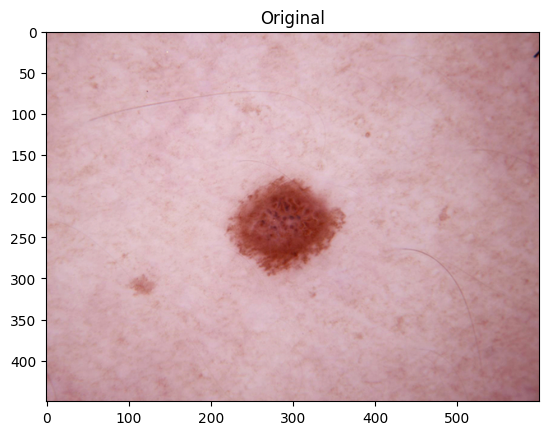

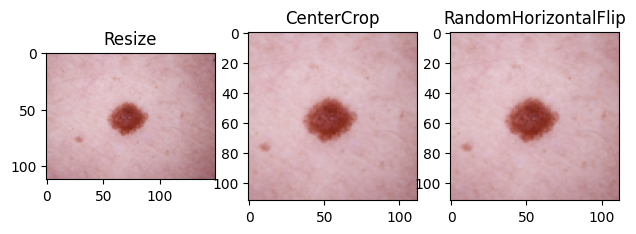

In [ ]:
# Code to visualize and decide data parameters
lesions = ISIC2018(train_df)

image, label = next(iter(lesions))

# Plot the original image
fig = plt.figure()
plt.imshow(image)
plt.title('Original')

# Transformations
resize = transforms.Resize(112)
crop = transforms.CenterCrop((112,112))
flip = transforms.RandomHorizontalFlip()

# Plot the image after the transformations
f = plt.figure(figsize=(10,10))
for i,tsfrm in enumerate([resize,crop,flip]):
  image = tsfrm(image)
  ax = f.add_subplot(1, 4, i + 1)
  ax.set_title(type(tsfrm).__name__)
  plt.imshow(image)

 ### First, import all libraries that used in this project

In [ ]:
%matplotlib inline
# python libraties
import os, cv2,itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
from PIL import Image

# pytorch libraries
import torch
from torch import optim,nn
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
from torchvision import models,transforms

# sklearn libraries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# to make the results are reproducible
np.random.seed(10)
torch.manual_seed(10)
torch.cuda.manual_seed(10)

#print(os.listdir("../input"))

In [ ]:
device = torch.device('cuda:0')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


## Step 1. Data analysis and preprocessing

Get the all image data paths， match the row information in HAM10000_metadata.csv with its corresponding image

This function is used to compute the mean and standard deviation on the whole dataset, will use for inputs normalization

Return the mean and std of RGB channels

In [ ]:
def compute_img_mean_std(image_paths):
    """
        computing the mean and std of three channel on the whole dataset,
        first we should normalize the image from 0-255 to 0-1
    """

    img_h, img_w = 224, 224
    imgs = []
    means, stdevs = [], []

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        imgs.append(img)

    print("imgs.shape")
    imgs = np.stack(imgs, axis=3)
    print(imgs.shape)

    imgs = imgs.astype(np.float32) / 255.

    i=2
    for i in range(3):
        print("Loop:" +str(i))
        pixels = imgs[:, :, i, :].ravel()  # resize to one row
        print("Loop:" +str(i)+".1")
        means.append(np.mean(pixels))
        print("Loop:" +str(i)+".2")
        stdevs.append(np.std(pixels))
        print("Loop:" +str(i)+".3")

    means.reverse()  # BGR --> RGB
    stdevs.reverse()

    print("normMean = {}".format(means))
    print("normStd = {}".format(stdevs))
    return means,stdevs


norm_mean,norm_std = compute_img_mean_std(all_image_path)
print(norm_mean)

print(norm_std)

In [ ]:

norm_mean,norm_std = [0.6843859, 0.5344464, 0.53196514], [0.2125198, 0.1949232, 0.20782322]

In [ ]:
df_original

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC,dx,path,cell_type,cell_type_idx
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Melanocytic nevi,4
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Melanocytic nevi,4
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Melanocytic nevi,4
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Melanocytic nevi,4
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Melanoma,5
...,...,...,...,...,...,...,...,...,...,...,...,...
10010,ISIC_0034316,1.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Melanoma,5
10011,ISIC_0034317,1.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Melanoma,5
10012,ISIC_0034318,0.0,0.0,0.0,0.0,1.0,0.0,0.0,BKL,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Benign keratosis-like lesions,2
10013,ISIC_0034319,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Melanocytic nevi,4


Add three columns to the original DataFrame, path (image path), cell_type (the whole name),cell_type_idx (the corresponding index  of cell type, as the image label )

In [ ]:
# this will tell us how many images are associated with each lesion_id
df_undup = df_original.groupby('cell_type_idx').count()
df_undup.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC,dx,path,cell_type
cell_type_idx,,,,,,,,,,,
0,327,327,327,327,327,327,327,327,327,327,327
1,514,514,514,514,514,514,514,514,514,514,514
2,1099,1099,1099,1099,1099,1099,1099,1099,1099,1099,1099
3,115,115,115,115,115,115,115,115,115,115,115
4,6705,6705,6705,6705,6705,6705,6705,6705,6705,6705,6705


In [ ]:
# This set will be df_original excluding all rows that are in the val set
# This function identifies if an image is part of the train or val set.
def get_val_rows(x):
    # create a list of all the lesion_id's in the val set
    val_list = list(val_df['image'])
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'

# identify train and val rows
# create a new colum that is a copy of the image_id column
df_original['train_or_val'] = df_original['image']
# apply the function to this new column
df_original['train_or_val'] = df_original['train_or_val'].apply(get_val_rows)
# filter out train rows
df_train = df_original[df_original['train_or_val'] == 'train']
print(len(df_train))
print(len(val_df))

8012
2003


In [ ]:
df_original['cell_type_idx'].value_counts()

,count
cell_type_idx,
4,6705
5,1113
2,1099
1,514
0,327
6,142
3,115


In [ ]:
val_df['cell_type'].value_counts()
val_df.size

24036

**From From the above statistics of each category, we can see that there is a serious class imbalance in the training data. To solve this problem, I think we can start from two aspects, one is equalization sampling, and the other is a loss function that can be used to mitigate category imbalance during training, such as focal loss.**

In [ ]:
import pandas as pd

# Copy fewer class to balance the number of 7 classes
data_aug_rate = [15, 10, 5, 50, 0, 40, 5]

for i in range(7):
    if data_aug_rate[i] > 1: # Only augment if rate is > 1

        # 1. Select the rows for the current minority class
        minority_subset = df_train.loc[df_train['cell_type_idx'] == i, :]

        # 2. Create the list of DataFrames to concatenate (duplicating the subset)
        # We need (data_aug_rate[i] - 1) copies to achieve the total rate
        copies_list = [minority_subset] * (data_aug_rate[i] - 1)

        # 3. Use pd.concat() to add the copies to df_train
        # pd.concat takes a list of DataFrames: [original_df, augmented_df1, augmented_df2, ...]
        df_train = pd.concat(
            [df_train] + copies_list,
            ignore_index=True
        )

# Display the new class distribution
print(df_train['cell_type'].value_counts())

cell_type
Melanoma                         35600
Melanocytic nevi                  5364
Dermatofibroma                    4600
Benign keratosis-like lesions     4395
Basal cell carcinoma              4110
Actinic keratoses                 3930
Vascular lesions                   570
Name: count, dtype: int64


In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split

# Create a copy of df_original to avoid modifying it in place
df_for_split = df_original.copy()

# Ensure 'cell_type_idx' is in df_for_split for the split operation.
# This re-creates it if it was removed by a prior operation or ensures it's current.
if 'cell_type_idx' not in df_for_split.columns:
    df_for_split['cell_type_idx'] = pd.Categorical(df_for_split['cell_type']).codes

# Separate features (X) and target (y) using column selection
y = df_for_split['cell_type_idx'].to_frame()
X = df_for_split.drop(columns=['cell_type_idx', 'train_or_val'], errors='ignore') # Drop target and temporary column if they exist

X_train_original, X_test_original, y_train_original, y_test_original = train_test_split(X, y, stratify=y, test_size=0.2)

train_df = pd.concat([X_train_original, y_train_original], axis=1, sort=False)
train_df = train_df.reset_index(drop=True)

val_df = pd.concat([X_test_original, y_test_original], axis=1, sort=False)
val_df = val_df.reset_index(drop=True)

# Get class counts for the training set
class_counts = train_df['cell_type_idx'].value_counts()

# Calculate class weights for WeightedRandomSampler
num_samples = len(train_df)
num_classes = len(class_counts)

class_weights = {}
for class_id in class_counts.index:
    class_weights[class_id] = num_samples / (class_counts[class_id] * num_classes)

sample_weights = [class_weights[class_id] for class_id in train_df['cell_type_idx']]
sample_weights = torch.DoubleTensor(sample_weights)

weighted_sampler = torch.utils.data.sampler.WeightedRandomSampler(
    sample_weights,
    num_samples,
    replacement=True
)

print("Class weights calculated and WeightedRandomSampler prepared.")
print(f"Original training DataFrame size: {len(train_df)} rows")
print(f"Validation DataFrame size: {len(val_df)} rows")

Class weights calculated and WeightedRandomSampler prepared.
Original training DataFrame size: 8012 rows
Validation DataFrame size: 2003 rows


At the beginning, I divided the data into three parts, training set, validation set and test set. Considering the small amount of data, I did not further divide the validation set data in practice.

In [ ]:
# # We can split the test set again in a validation set and a true test set:
# df_val, df_test = train_test_split(df_val, test_size=0.5)
df_train = df_train.reset_index()

val_df = val_df.reset_index()
# df_test = df_test.reset_index()

In [ ]:
for index, rows in val_df.iterrows():
    # print(index, rows.path)
    if rows.path is None:
        val_df = val_df.drop(index)
    else:
        if rows.path.endswith('.png'):
            try:
                img = Image.open('./'+filename) # open the image file
                img.verify() # verify that it is, in fact an image
            except (IOError, SyntaxError) as e:
                val_df = val_df.drop(index)
                # print('Bad file:', filename) # print out the names of corrupt files

In [ ]:
df_train.size

819966

In [ ]:
for index, rows in df_train.iterrows():
    # print(index, rows.path)
    if rows.path is None:
        df_train = df_train.drop(index)
    else:
        if rows.path.endswith('.png'):
            try:
                img = Image.open('./'+filename) # open the image file
                img.verify() # verify that it is, in fact an image
            except (IOError, SyntaxError) as e:
                df_train = df_train.drop(index)
                print('Bad file:', filename) # print out the names of corrupt files

In [ ]:
df_train.head()

,index,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC,dx,path,cell_type,cell_type_idx,train_or_val
0,0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Melanocytic nevi,4,train
1,1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Melanocytic nevi,4,train
2,2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Melanocytic nevi,4,train
3,3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Melanocytic nevi,4,train
4,4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Melanoma,5,train


In [ ]:
val_df.size
print(df_train.size)

819966


In [ ]:
val_df.head()

,index,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC,dx,path,cell_type,cell_type_idx
0,0,ISIC_0033471,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Melanocytic nevi,4
1,1,ISIC_0024479,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Melanocytic nevi,4
2,2,ISIC_0032777,0.0,0.0,1.0,0.0,0.0,0.0,0.0,BCC,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Basal cell carcinoma,1
3,3,ISIC_0033518,1.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Melanoma,5
4,4,ISIC_0024762,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Melanocytic nevi,4


## Step 2. Model building

In [ ]:
# feature_extract is a boolean that defines if we are finetuning or feature extracting.
# If feature_extract = False, the model is finetuned and all model parameters are updated.
# If feature_extract = True, only the last layer parameters are updated, the others remain fixed.
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18, resnet34, resnet50, resnet101
        """
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224


    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224


    elif model_name == "densenet":
        """ Densenet121
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        #input_size = 299
        input_size = 224

    else:
        print("Invalid model name, exiting...")
        exit()
    return model_ft, input_size

In [ ]:
# resnet,vgg,densenet,inception
model_name = 'densenet'
num_classes = 7 # Corrected to 7 based on the data analysis, previously 9
feature_extract = False
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
# Define the device:
#device = torch.device('cuda:0')
# Put the model on the device:
model = model_ft.to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 137MB/s]


In [ ]:
# norm_mean = (0.49139968, 0.48215827, 0.44653124)
# norm_std = (0.24703233, 0.24348505, 0.26158768)
# define the transformation of the train images.
train_transform = transforms.Compose([transforms.Resize((input_size,input_size)),transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),transforms.RandomRotation(20),
                                      transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
                                        transforms.ToTensor(), transforms.Normalize(norm_mean, norm_std)])

# define the transformation of the val images.
val_transform = transforms.Compose([transforms.Resize((input_size,input_size)), transforms.ToTensor(),
                                    transforms.Normalize(norm_mean, norm_std)])

In [ ]:
# Define a pytorch dataloader for this dataset
class HAM10000(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # Load data and get label
        X = Image.open(self.df['path'][index])
        #print(X)
        #plt.imshow(X)
        #plt.show()
        y = torch.tensor(int(self.df['cell_type_idx'][index]))
        #print(torch.tensor(int(self.df['cell_type_idx'][index])))

        if self.transform:
            X = self.transform(X)

        return X, y

In [ ]:

# print(training_set.__getitem__(32))
# print(df_train)

In [ ]:
df_train = df_train.reset_index()

val_df = val_df.reset_index()

In [ ]:
# Define the training set using the table train_df and using our defined transitions (train_transform)
training_set = HAM10000(train_df, transform=train_transform)

# Use the weighted_sampler for the training DataLoader
train_loader = DataLoader(training_set, batch_size=32, sampler=weighted_sampler, num_workers=4)

# Same for the validation set:
validation_set = HAM10000(val_df, transform=val_transform) # Using val_transform for validation
val_loader = DataLoader(validation_set, batch_size=32, shuffle=False, num_workers=4)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# we use Adam optimizer, use cross entropy loss as our loss function
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss().to(device)
#criterion = nn.CrossEntropyLoss()

1
2


torch.Size([32, 3, 224, 224])


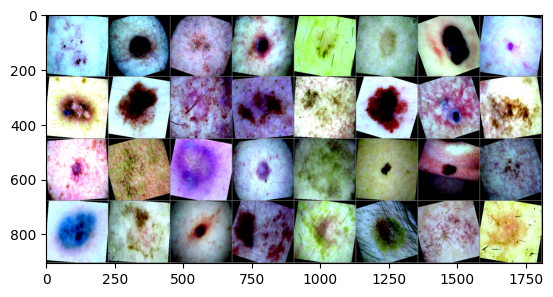

NV
BCC
NV
VASC
NV
AKIEC
VASC
VASC
AKIEC
DF
MEL
DF
MEL
DF
VASC
MEL
VASC
BCC
AKIEC
AKIEC
BCC
BKL
DF
BCC
VASC
MEL
VASC
DF
MEL
BCC
MEL
NV


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
batch_size=32
# functions to show an image


print("1")

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

print("2")
# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(images.shape)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
keys_list = list(lesion_type_dict.keys())
for j in range(batch_size):
    # Ensure labels[j] is a valid index for keys_list
    if labels[j] < len(keys_list):
        print( keys_list[labels[j]])
    else:
        print(f"Label index {labels[j]} out of bounds for keys_list ({len(keys_list)} elements).")


#print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

## Step 3. Model training

In [ ]:
# this function is used during training process, to calculation the loss and accuracy
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

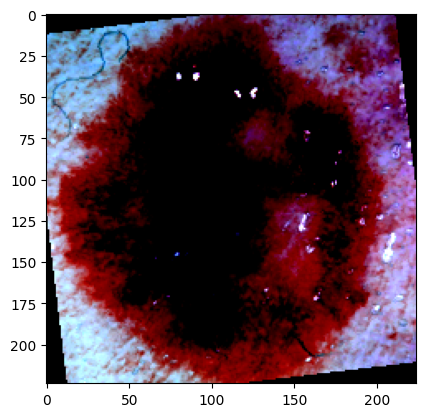

In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
plt.imshow(np.transpose(images[1]))

In [ ]:
total_loss_train, total_acc_train = [],[]
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
def train(train_loader, model, criterion, optimizer, epoch):
    model.train()
    train_loss = AverageMeter()
    train_acc = AverageMeter()
    curr_iter = (epoch - 1) * len(train_loader)
    for i, data in enumerate(train_loader):
        images, labels = data
        print(i,images.shape)
        N = images.size(0)
        # print('image shape:',images.size(0), 'label shape',labels.size(0))
        # print(images.shape)
        #plt.imshow(torchvision.utils.make_grid(images))
        #plt.show()
        # show images
        #imshow(torchvision.utils.make_grid(images))

        images = Variable(images).to(device)
        labels = Variable(labels).to(device)
        #images = Variable(images)
        #labels = Variable(labels)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        prediction = outputs.max(1, keepdim=True)[1]
        train_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)
        train_loss.update(loss.item())
        curr_iter += 1
        if (i + 1) % 100 == 0:
            print('[epoch %d], [iter %d / %d], [train loss %.5f], [train acc %.5f]' % (
                epoch, i + 1, len(train_loader), train_loss.avg, train_acc.avg))
            total_loss_train.append(train_loss.avg)
            total_acc_train.append(train_acc.avg)
    return train_loss.avg, train_acc.avg

In [ ]:
# !pip install dill

In [ ]:

import dill as dill
def validate(val_loader, model, criterion, optimizer, epoch):
    model.eval()
    val_loss = AverageMeter()
    val_acc = AverageMeter()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            images, labels = data
            #print(images.shape)
            N = images.size(0)
            images = Variable(images).to(device)
            labels = Variable(labels).to(device)
            #images = Variable(images)
            #labels = Variable(labels)

            outputs = model(images)
            prediction = outputs.max(1, keepdim=True)[1]

            val_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)

            val_loss.update(criterion(outputs, labels).item())

    print('------------------------------------------------------------')
    print('[epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, val_loss.avg, val_acc.avg))
    print('------------------------------------------------------------')
    return val_loss.avg, val_acc.avg


In [ ]:
# model = model
# PATH1 = "model/checkpoint/densenet_epoch9.pt"
# optimizer = optim.Adam(model.parameters(), lr=1e-3)
# criterion = nn.CrossEntropyLoss().to(device)
# checkpoint = torch.load(PATH1)
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

In [ ]:
CUDA_LAUNCH_BLOCKING=1
epoch_num = 10
best_val_acc = 0
least_loss = 100

total_loss_val, total_acc_val = [],[]
for epoch in range(10, epoch_num+1): # Start from epoch 1
    print(f"Starting Epoch {epoch}")
    loss_train, acc_train = train(train_loader, model, criterion, optimizer, epoch)
    loss_val, acc_val = validate(val_loader, model, criterion, optimizer, epoch)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)

    if least_loss > loss_val:
        least_loss = loss_val

    # Ensure the directory exists for saving checkpoints
    os.makedirs('model/checkpoint', exist_ok=True)

    if acc_val > best_val_acc:
        best_val_acc = acc_val
        PATH = "model/densenet_epoch"+str(epoch)+".h5"
        torch.save(model, PATH, pickle_module=dill)
        print("Model Saved")
        PATH1 = "model/checkpoint/densenet_epoch"+str(epoch)+".pt"
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': least_loss,
            }, PATH1)
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')


Starting Epoch 10
0 torch.Size([32, 3, 224, 224])
1 torch.Size([32, 3, 224, 224])
2 torch.Size([32, 3, 224, 224])
3 torch.Size([32, 3, 224, 224])
4 torch.Size([32, 3, 224, 224])
5 torch.Size([32, 3, 224, 224])
6 torch.Size([32, 3, 224, 224])
7 torch.Size([32, 3, 224, 224])
8 torch.Size([32, 3, 224, 224])
9 torch.Size([32, 3, 224, 224])
10 torch.Size([32, 3, 224, 224])
11 torch.Size([32, 3, 224, 224])
12 torch.Size([32, 3, 224, 224])
13 torch.Size([32, 3, 224, 224])
14 torch.Size([32, 3, 224, 224])
15 torch.Size([32, 3, 224, 224])
16 torch.Size([32, 3, 224, 224])
17 torch.Size([32, 3, 224, 224])
18 torch.Size([32, 3, 224, 224])
19 torch.Size([32, 3, 224, 224])
20 torch.Size([32, 3, 224, 224])
21 torch.Size([32, 3, 224, 224])
22 torch.Size([32, 3, 224, 224])
23 torch.Size([32, 3, 224, 224])
24 torch.Size([32, 3, 224, 224])
25 torch.Size([32, 3, 224, 224])
26 torch.Size([32, 3, 224, 224])
27 torch.Size([32, 3, 224, 224])
28 torch.Size([32, 3, 224, 224])
29 torch.Size([32, 3, 224, 224])
30

## Step 4. Model evaluation

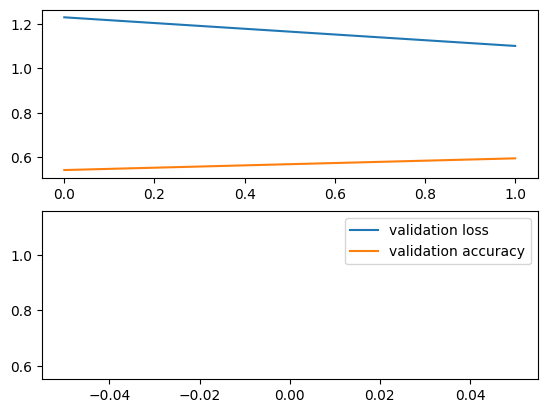

In [ ]:
fig = plt.figure(num = 2)
fig1 = fig.add_subplot(2,1,1)
fig2 = fig.add_subplot(2,1,2)
fig1.plot(total_loss_train, label = 'training loss')
fig1.plot(total_acc_train, label = 'training accuracy')
fig2.plot(total_loss_val, label = 'validation loss')
fig2.plot(total_acc_val, label = 'validation accuracy')
plt.legend()
plt.show()

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

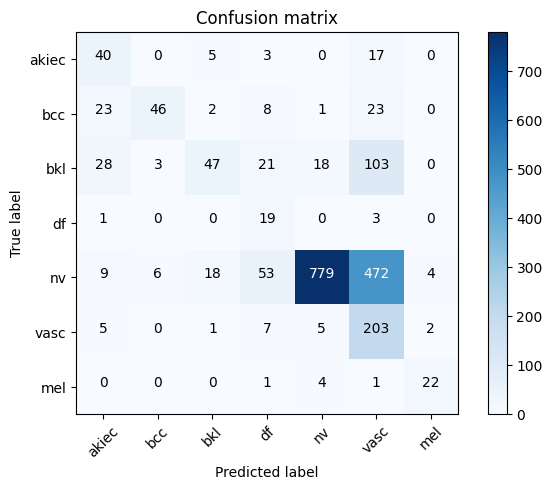

In [ ]:
model.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(val_loader):
        images, labels = data
        N = images.size(0)
        #images = Variable(images)
        images = Variable(images).to(device)
        outputs = model(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
plot_confusion_matrix(confusion_mtx, plot_labels)

In [ ]:
# Generate a classification report
report = classification_report(y_label, y_predict, target_names=plot_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.38      0.62      0.47        65
         bcc       0.84      0.45      0.58       103
         bkl       0.64      0.21      0.32       220
          df       0.17      0.83      0.28        23
          nv       0.97      0.58      0.73      1341
        vasc       0.25      0.91      0.39       223
         mel       0.79      0.79      0.79        28

    accuracy                           0.58      2003
   macro avg       0.58      0.63      0.51      2003
weighted avg       0.81      0.58      0.62      2003



Text(0, 0.5, 'Fraction classified incorrectly')

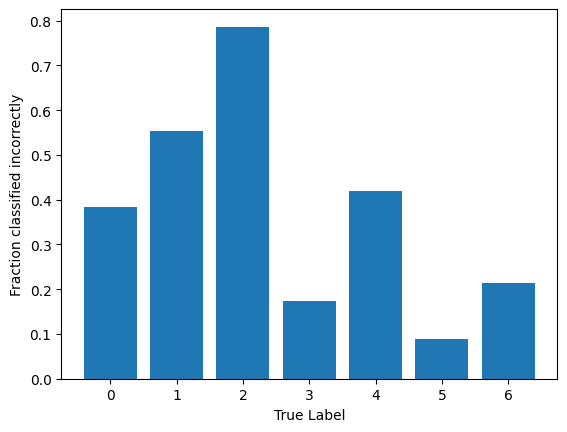

In [ ]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')